In [1]:
import numpy as np
import suite2p
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Sequence, Dict, Any
from scipy.stats import kde, pearsonr
import numpy as np
import pandas as pd
import os
import pickle
from scipy.signal import find_peaks
import cottage_analysis as cott
from cottage_analysis.imaging.common import align_timestamps, find_frames
import pickle


# Suite2p visualization

## Filepath

In [2]:
# filepath
rawdata_root = '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/'
root = '/camp/lab/znamenskiyp/home/shared/projects/'
project = 'hey2_3d-vision_20210716'
data_dir = ''
mouse = 'PZAH2.1b'
session = 'S20210916'
recording = 'R163430'
protocol = 'SphereSparseNoise'
suite2p_dir = 'suite2p_rois_0/suite2p/plane0/'
trace_dir = 'suite2p_traces_0/'

def generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol):
    rawdata_folder = rawdata_root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    preprocess_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    analysis_folder = root + project + '/' + data_dir + 'Analysis/' + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    
    return rawdata_folder, preprocess_folder, analysis_folder

def generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir):
    suite2p_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + suite2p_dir
    protocol_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    trace_folder = protocol_folder +  protocol + '_' + trace_dir
    
    return suite2p_folder, protocol_folder, trace_folder


rawdata_folder, preprocess_folder, analysis_folder = generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol)
print(rawdata_folder, preprocess_folder, analysis_folder)

suite2p_folder, protocol_folder, trace_folder = generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir)
print(suite2p_folder, protocol_folder, trace_folder)

if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)
print(trace_folder)
    

/camp/lab/znamenskiyp/data/instruments/raw_data/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/Analysis/PZAH2.1b/S20210916/R163430_SphereSparseNoise/
/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/suite2p_rois_0/suite2p/plane0/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/SphereSparseNoise_suite2p_traces_0/
/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/SphereSparseNoise_suite2p_traces_0/


## Load files

In [3]:
# Load files
F = np.load(suite2p_folder+'F.npy', allow_pickle=True)
Fneu = np.load(suite2p_folder+'Fneu.npy', allow_pickle=True)
spks = np.load(suite2p_folder+'spks.npy', allow_pickle=True)
stat = np.load(suite2p_folder+'stat.npy', allow_pickle=True)
ops =  np.load(suite2p_folder+'ops.npy', allow_pickle=True)
ops = ops.item()
iscell = np.load(suite2p_folder+'iscell.npy', allow_pickle=True)[:,0]
output_op = ops

## Extract Traces

In [4]:
# f_cells = np.load(Path(output_op['save_path']).joinpath('F.npy'))
# f_neus = np.load(Path(output_op['save_path']).joinpath('Fneu.npy'))
# spks = np.load(Path(output_op['save_path']).joinpath('spks.npy'))
# f_cells.shape, f_neus.shape, spks.shape

In [4]:
f_cells = np.load(Path(trace_folder).joinpath('F.npy'))
f_neus = np.load(Path(trace_folder).joinpath('Fneu.npy'))
spks = np.load(Path(trace_folder).joinpath('spks.npy'))
f_ast = np.load(Path(trace_folder).joinpath('Fast.npy'))
f_cells.shape, f_neus.shape, spks.shape, f_ast.shape

((359, 184409), (359, 184409), (359, 184409), (359, 184409))

# Process vis-stim loggers & harp

## Process vis-stim info

In [5]:
with open(protocol_folder+'img_VS.pickle', 'rb') as handle:
    img_VS = pickle.load(handle)
    
img_VS['Stim'] = np.nan
img_VS.loc[img_VS.Depth.notnull(), 'Stim'] = 1
img_VS.loc[img_VS.Depth<0, 'Stim'] = 0
img_VS.loc[((img_VS[img_VS.Depth<0]).index.values-1),'Stim'] = 0

img_VS_simple = img_VS[(img_VS['Stim'].diff()!=0) & (img_VS['Stim'].notnull())]
img_VS_simple.Depth = np.round(img_VS_simple.Depth,2)
img_VS_simple

/camp/home/hey2/.conda/envs/2p_analysis/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,HarpTime,ImagingFrame,Photodiode,ElapsedTime,VisStim_Frame,SphereID,Depth,Azimuth,Elevation,EyeZ,Stim
1241,4.571217e+06,1241,21,47.696992,5135,1.0,0.20,10.0,5.0,7.080702,1.0
2134,4.571247e+06,2134,12,77.486976,8425,1511.0,0.20,20.0,-25.0,12.921180,0.0
2436,4.571257e+06,2436,12,87.580000,9241,1517.0,0.63,150.0,-40.0,15.660563,1.0
3333,4.571287e+06,3333,196,117.524992,12502,3029.0,0.63,-10.0,-35.0,19.599519,0.0
3635,4.571297e+06,3635,203,127.597984,13624,3033.0,2.00,50.0,20.0,22.395353,1.0
...,...,...,...,...,...,...,...,...,...,...,...
178352,4.577130e+06,178352,13,5959.870976,655801,225175.0,0.20,130.0,5.0,830.200066,0.0
178653,4.577140e+06,178653,201,5969.921984,656928,225179.0,0.63,-20.0,-40.0,832.088397,1.0
179551,4.577170e+06,179551,14,5999.876000,660095,226714.0,0.63,180.0,40.0,833.793877,0.0
179852,4.577180e+06,179852,19,6009.948000,661199,226719.0,2.00,-10.0,-35.0,835.118776,1.0


In [6]:
# Find the frame number of each vis-stim trial
depth_list = [0.2, 0.63, 2]
stim_dict = {}
for istim in depth_list:  
    stim_dict['stim'+str(istim)] = {}
    stim_dict['stim'+str(istim)]['start'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==1)].index.values
    stim_dict['stim'+str(istim)]['stop'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==0)].index.values

In [7]:
# Find frames for blank period
blank_points = img_VS_simple.index.values[1:-1]
stim_dict['blank'] = {}
stim_dict['blank']['start'] = blank_points[0::2] + 1
stim_dict['blank']['stop'] = blank_points[1::2] - 1

stim_dict

{'stim0.2': {'start': array([  1241,   6032,   8430,  13225,  16822,  21618,  24016,  27612,
          32408,  33607,  37203,  43197,  45595,  50391,  53987,  56385,
          59981,  64775,  67173,  70770,  73168,  77964,  80361,  85156,
          87555,  91152,  95946,  98344, 101940, 107933, 111529, 113927,
         117523, 121118, 125913, 129508, 130708, 135502, 137898, 141495,
         146289, 148687, 152283, 158277, 161872, 164270, 167866, 170263,
         176256, 177454]),
  'stop': array([  2134,   6929,   9327,  14123,  17720,  22515,  24913,  28509,
          33305,  34504,  38101,  44095,  46493,  51288,  54884,  57282,
          60878,  65673,  68071,  71668,  74065,  78861,  81258,  86054,
          88452,  92049,  96843,  99241, 102837, 108830, 112426, 114825,
         118420, 122015, 126809, 130406, 131604, 136399, 138796, 142392,
         147187, 149584, 153180, 159174, 162769, 165167, 168763, 171160,
         177153, 178352])},
 'stim0.63': {'start': array([  2436,   4

# Model fitting

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import motion_model as mm
from motion_model.util import lag_tensor
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
import graphviz
import optax

In [9]:
# dF/F
def dFF(f_cells):
    f_mean = np.average(f_cells,axis=1).reshape(-1,1)
    dffs = (f_cells-f_mean)/f_mean
    return dffs
dffs = dFF(f_cells)
dffs_ast = dFF(f_ast)
dffs.shape, dffs_ast.shape

((359, 184409), (359, 184409))

(2133    32.149298
 2134    24.875364
 2135    22.045233
 dtype: float64,
 2133    0.2
 2134    0.2
 2135    NaN
 Name: Depth, dtype: float64,
 array([1.60746489, 1.2437682 ,        nan]))

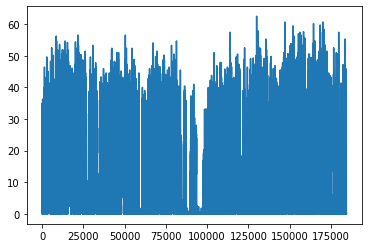

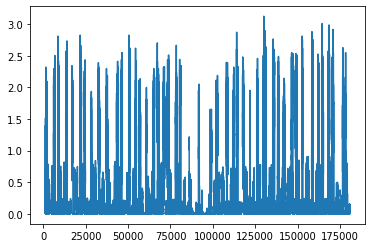

In [10]:
# Speed (Unit: cm/s)
speeds = img_VS.EyeZ.diff()/img_VS.HarpTime.diff()*100
speeds[0] = 0


# Process speed: take abs, thresholding
def thr(arr, thr):
#     arr = np.abs(arr)
    arr[arr<thr] = thr
    
    return arr

speeds = thr(speeds, thr=0.01)
plt.figure()
plt.plot(speeds)

# Optic flow (Unit: rad/s)
all_depths = img_VS.Depth.replace(-99.99,np.nan)
optics = speeds/(all_depths*100)
optics = np.array(optics)
plt.figure()
plt.plot(optics)
speeds[2133:2136], all_depths[2133:2136], optics[2133:2136]


In [11]:
# Select which rois to visualize 
which_rois = (np.arange(f_cells.shape[0]))[iscell.astype('bool')]
which_rois

array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  38,  39,  41,
        42,  43,  44,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  83,  84,
        85,  86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 104, 105, 107, 108, 109, 110, 111, 112, 114,
       115, 116, 117, 118, 120, 121, 122, 124, 125, 127, 128, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 158, 159,
       161, 163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 177, 178,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 20

In [12]:
# Utils
# Find the min trial number for all depths
def find_min_trial_num_all_depths(stim_dict, depth_list, isStim=True):
    if isStim:
        trial_nums = []
        for idepth in range(len(depth_list)):
            depth = depth_list[idepth]
            frame_dict = stim_dict['stim'+str(depth)]
            trial_nums.append(len(frame_dict['start']))
        trial_nums = np.array(trial_nums)
    #     if np.all(trial_nums==trial_nums[0]):
    #         print('Checked all trial nums are the same')
        if not np.all(trial_nums==trial_nums[0]):
            print('Trials nums are not the same. Take the min trial num.')
        trial_num = np.min(trial_nums)
    else: 
        trial_num = len(stim_dict['blank']['stop'])
    
    return trial_num


# Find the min frame number of each trial for each ROI
def find_min_frame_num_per_trial(depth_list, stim_dict, isStim=True):
    if isStim: 
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list)
        frame_num_arr = np.zeros((len(depth_list),trial_num))
        for idepth in range(len(depth_list)):
            for itrial in range(trial_num):
                frame_start = stim_dict['stim'+str(depth_list[idepth])]['start'][itrial]
                frame_stop = stim_dict['stim'+str(depth_list[idepth])]['stop'][itrial]
                frame_num = frame_stop - frame_start+1
                frame_num_arr[idepth, itrial] = frame_num
    else:
        trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=False)
        frame_num_arr = np.zeros(trial_num)
        for itrial in range(trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            frame_stop = stim_dict['blank']['stop'][itrial]
            frame_num = frame_stop - frame_start+1
            frame_num_arr[itrial] = frame_num
    
    return int(np.min(frame_num_arr))


# Create an array to store the traces for each roi, format: depth x trial x frames_per_trial
def create_trace_arr_per_roi(which_roi, dffs, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30):
    trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
    frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
    frame_num_pertrial = frame_num_pertrial + blank_period*frame_rate*2
    dff = dffs[which_roi,:]
    

    if isStim:
        trace_arr = np.zeros((len(depth_list),trial_num, frame_num_pertrial))

        for idepth in range(0,len(depth_list)):
            depth = depth_list[idepth]
            for itrial in range(0, trial_num):
                frame_start = stim_dict['stim'+str(depth)]['start'][itrial] - blank_period*frame_rate
                trace_arr[idepth, itrial,:] = dff[frame_start:(frame_start+frame_num_pertrial)]

    
    else:
        trace_arr = np.zeros((1,trial_num, frame_num_pertrial))

        for itrial in range(0, trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            trace_arr[0, itrial,:] = dff[frame_start:(frame_start+frame_num_pertrial)]
        
    
    return trace_arr


# Create an array to store the speed for each trial, format: depth x trial x frames_per_trial
def create_speed_arr(speeds, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30):
    trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
    frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
    frame_num_pertrial = frame_num_pertrial + blank_period*frame_rate*2
    
    if isStim:
        speed_arr = np.zeros((len(depth_list),trial_num, frame_num_pertrial))

        for idepth in range(0,len(depth_list)):
            depth = depth_list[idepth]
            for itrial in range(0, trial_num):
                frame_start = stim_dict['stim'+str(depth)]['start'][itrial] - blank_period*frame_rate
                speed_arr[idepth, itrial,:] = speeds[frame_start:(frame_start+frame_num_pertrial)]

    else:
        speed_arr = np.zeros((1,trial_num, frame_num_pertrial))

        for itrial in range(0, trial_num):
            frame_start = stim_dict['blank']['start'][itrial]
            speed_arr[0, itrial,:] = speeds[frame_start:(frame_start+frame_num_pertrial)]

    
    return speed_arr


def create_optic_flow_arr(speed_arr, depth_list):
    optic_arr = np.zeros(speed_arr.shape)
    for idepth in range(len(depth_list)):
        optic_arr[idepth,:,:] = speed_arr[idepth,:,:]/depth_list[idepth]
    
    return optic_arr


def normalize_scale(arr, average_axis=1, scalek=1):
    if average_axis==1:
        arr_normed = (arr - np.average(arr, axis=average_axis).reshape(-1,1))/(np.max(arr,axis=average_axis)-np.min(arr,axis=average_axis)).reshape(-1,1)
    elif average_axis==0:
        arr_normed = (arr - np.average(arr, axis=average_axis))/(np.max(arr)-np.min(arr))

    arr_scaled = arr_normed * scalek
            
    
    return arr_scaled


def segment_arr(arr_idx, segment_size):
    batch_num = len(arr_idx)//segment_size
    segment_starts = np.arange(0,batch_num*segment_size+1,segment_size)
    segment_ends = np.arange(segment_size,batch_num*segment_size+segment_size,segment_size)
    if len(arr_idx)%segment_size!=0:
        segment_ends = np.concatenate((segment_ends, (arr_idx[-1]+1).reshape(-1)))
    segment_starts = (segment_starts+arr_idx[0])[:len(segment_ends)]
    segment_ends = segment_ends+arr_idx[0]
    
    return segment_starts, segment_ends 


isStim = True
trial_num = find_min_trial_num_all_depths(stim_dict, depth_list, isStim=isStim)
frame_num_pertrial = find_min_frame_num_per_trial(depth_list, stim_dict, isStim=isStim)
trace_arr = create_trace_arr_per_roi(0,dffs, depth_list, stim_dict, isStim=isStim)
speed_arr = create_speed_arr(speeds, depth_list, stim_dict, isStim=isStim)
segment_starts, segment_ends = segment_arr(arr_idx=np.arange(20,100,1), segment_size = 20)
trial_num, frame_num_pertrial, trace_arr.shape, speed_arr.shape, segment_starts, segment_ends



(50,
 894,
 (3, 50, 894),
 (3, 50, 894),
 array([20, 40, 60, 80]),
 array([ 40,  60,  80, 100]))

In [13]:
# Process RS & OF data
# Lag array
frame_rate = 30
rs_lag_min = -0.5
rs_lag_max = 1
of_lag_min = 0
of_lag_max = 1

rs_lags = lag_tensor(speeds, nlags_min=int(frame_rate*rs_lag_min), nlags_max = int(frame_rate*rs_lag_max))
of_lags = lag_tensor(optics, nlags_min=int(frame_rate*of_lag_min), nlags_max = int(frame_rate*of_lag_max))

# For each lag column, find the rows for stim frames
(ndepths, ntrials, nframes) = create_speed_arr(speeds, depth_list, stim_dict, isStim=True).shape
rs_stim = np.zeros((rs_lags.shape[1], ndepths, ntrials, nframes))
of_stim = np.zeros((of_lags.shape[1], ndepths, ntrials, nframes))
for icol in range(rs_lags.shape[1]):
    rs_stim[icol] = create_speed_arr(rs_lags[:,icol], depth_list, stim_dict, isStim=True)
for icol in range(of_lags.shape[1]):
    of_stim[icol] = create_speed_arr(of_lags[:,icol], depth_list, stim_dict, isStim=True)
    
# replace nan with 0: HOW TO DEAL WITH NAN IN OF? 
# Thresholding OF
of_stim = np.nan_to_num(of_stim)
of_stim = thr(of_stim, thr=0.0001)

# Log RS & OF
rs_stim_analysis = np.log(rs_stim)
of_stim_analysis = np.log(of_stim)

# discard_idx_ends = (pd.Series(arr))[(pd.Series(arr)).rolling(window).mean()==thr].index.values
# discard_idx = np.array(list(set(np.array([np.arange(i-window,i,1) for i in discard_idx_ends]).flatten()))).astype('int')


In [14]:
seed=42
lr=1e-2
nepoches = 3
batch_size = 1000
loss_history = []
grads_history = []

# trace_arr 
choose_roi = 0
trace_arr = create_trace_arr_per_roi(choose_roi, dffs, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30)
rs_stim_analysis_selected = rs_stim_analysis[:,:,:,:].reshape(rs_stim_analysis.shape[0],-1).T
of_stim_analysis_selected = of_stim_analysis[:,:,:,:].reshape(of_stim_analysis.shape[0],-1).T
trace_arr_selected = trace_arr[:,:,:].flatten()

rs_x = rs_stim_analysis_selected
of_x = of_stim_analysis_selected
spikes = trace_arr_selected
nbatches = int(np.ceil(len(spikes)/batch_size))

# Initialization
rng_key = jax.random.PRNGKey(seed)
params = mm.model.rs_of_integration.init(rng=rng_key, rs=rs_x, of=of_x)
opt = optax.adam(lr)
opt_state = opt.init(params)

# Stratify data 
from random import shuffle
def stratify_index(data, batch_size, nbatches=None):
    '''Stratify data into mini batches'''
    nrows = data.shape[0]
    rows = np.arange(nrows)   
    shuffle(rows)
    stratified_idx = []
    if nbatches!=None:
        batch_size = nrows//nbatches
    else:
        nbatches = int(np.ceil(nrows/batch_size))
    for i in range(nbatches-1):
        stratified_idx.append(rows[i*batch_size:(i+1)*batch_size])
    stratified_idx.append(rows[batch_size*(nbatches-1):])
    return stratified_idx


# Training
@jax.jit
def update(params, rs, of, spikes, opt_state):
    """Apply optimizer."""
    nll, grads = jax.value_and_grad(mm.model.rs_of_integration_loss)(params, rs_x, of_x, spikes)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, nll, grads


for iepoch in range(nepoches):
    stratified_idx = stratify_index(spikes,batch_size=batch_size)
    
    for ibatch in range(nbatches):
        spikes_mini = jnp.array(spikes[stratified_idx[ibatch]])
        rs_x_mini = jnp.array(rs_x[stratified_idx[ibatch]])
        of_x_mini = jnp.array(of_x[stratified_idx[ibatch]])
        

        for step in range(300):
            params, opt_state, nll, grads = update(params, rs_x_mini, of_x_mini, spikes_mini, opt_state)
            if step % 300 == 0:
                print(f"[Step {step}] nll: {nll:.3f}")

            loss_history.append(nll)
            grads_history.append(grads)
            

        with open('params.pickle', 'wb') as handle:
            pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
np.save('loss_history.npy',loss_history)
np.save('grads.npy',grads_history)

# with open('params.pickle', 'rb') as handle:
#     params_saved = pickle.load(handle)


plt.figure(figsize=(15,10))
plt.subplot(321)
plt.plot(loss_history)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(322)
plt.plot(spikes, label='Data')
plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x), label='Model fit')
plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1])))

plt.subplot(323)
x_axis = np.arange(-20,20,0.001)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])))
plt.title('Gaussian kernel for RS, mu='+str(np.round(np.array(params['gaussian_module']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module']['log_sigma']),2)))

plt.subplot(324)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])))
plt.title('Gaussian kernel for OF, mu='+str(np.round(np.array(params['gaussian_module_1']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module_1']['log_sigma']),2)))

plt.subplot(325)
plt.plot(np.linspace(-0.5,1,int(frame_rate*(1-(-0.5)))),params['linear']['w'])
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for RS')

plt.subplot(326)
plt.plot(np.linspace(0,1,int(frame_rate*(1-(0)))),params['linear_1']['w'])
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for OF')

plt.tight_layout(pad=1)



[Step 0] nll: 829221184.000
[Step 0] nll: 31699540.000
[Step 0] nll: 30486184.000
[Step 0] nll: 29843694.000
[Step 0] nll: 31366878.000
[Step 0] nll: 25411312.000
[Step 0] nll: 33269174.000
[Step 0] nll: 37564440.000
[Step 0] nll: 33000986.000
[Step 0] nll: 26129900.000
[Step 0] nll: 28268820.000
[Step 0] nll: 36692128.000
[Step 0] nll: 35966536.000
[Step 0] nll: 33060988.000
[Step 0] nll: 37321704.000
[Step 0] nll: 28907598.000
[Step 0] nll: 39645624.000
[Step 0] nll: 34361288.000
[Step 0] nll: 32227492.000
[Step 0] nll: 27993994.000
[Step 0] nll: 33065402.000
[Step 0] nll: 34527244.000
[Step 0] nll: 38304488.000
[Step 0] nll: 26874322.000
[Step 0] nll: 32542750.000
[Step 0] nll: 24954506.000
[Step 0] nll: 32960792.000
[Step 0] nll: 20877268.000
[Step 0] nll: 41353716.000
[Step 0] nll: 33826256.000
[Step 0] nll: 35720088.000
[Step 0] nll: 33392682.000
[Step 0] nll: 25898152.000
[Step 0] nll: 26053844.000
[Step 0] nll: 35525368.000
[Step 0] nll: 26809928.000
[Step 0] nll: 36909200.000


KeyboardInterrupt: 

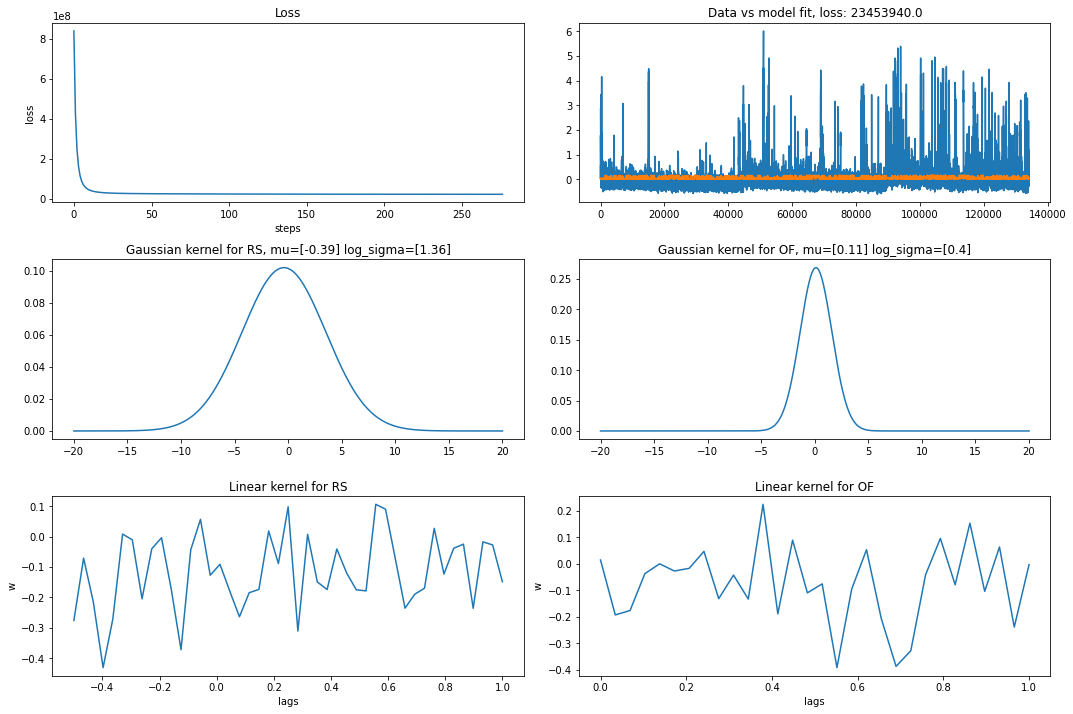

In [16]:
# with open('params.pickle', 'rb') as handle:
#     params = pickle.load(handle)

# loss_history = np.load('loss_history.npy')
# grads_history = np.load('grads_history.npy')

plt.figure(figsize=(15,10))
plt.subplot(321)
plt.plot(loss_history)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(322)
plt.plot(spikes, label='Data')
plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x), label='Model fit')
plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1])))

plt.subplot(323)
x_axis = np.arange(-20,20,0.001)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])))
plt.title('Gaussian kernel for RS, mu='+str(np.round(np.array(params['gaussian_module']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module']['log_sigma']),2)))

plt.subplot(324)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])))
plt.title('Gaussian kernel for OF, mu='+str(np.round(np.array(params['gaussian_module_1']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module_1']['log_sigma']),2)))

plt.subplot(325)
plt.plot(np.linspace(-0.5,1,int(frame_rate*(1-(-0.5)))),params['linear']['w'])
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for RS')

plt.subplot(326)
plt.plot(np.linspace(0,1,int(frame_rate*(1-(0)))),params['linear_1']['w'])
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for OF')

plt.tight_layout(pad=1)

In [27]:
# Set-up
seed=42
lr=1e-2
nepoches = 2
batch_size = 1000
ntrials_selected = 50
issave=False
save_prefix = 'plots/modelling/'

if issave:
    if not os.path.exists(analysis_folder+save_prefix):
        os.makedirs(analysis_folder+save_prefix)
rois_mins, rois_maxs = segment_arr(np.arange(0,len(which_rois),1), segment_size = 10)


# Function for training params
@jax.jit
def update(params, rs, of, spikes, opt_state):
    """Apply optimizer."""
    nll, grads = jax.value_and_grad(mm.model.rs_of_integration_loss)(params, rs_x, of_x, spikes)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, nll, grads

# Function for stratify data 
from random import shuffle
def stratify_index(data, batch_size, nbatches=None):
    '''Stratify data into mini batches'''
    nrows = data.shape[0]
    rows = np.arange(nrows)   
    shuffle(rows)
    stratified_idx = []
    if nbatches!=None:
        batch_size = nrows//nbatches
    else:
        nbatches = int(np.ceil(nrows/batch_size))
    for i in range(nbatches-1):
        stratified_idx.append(rows[i*batch_size:(i+1)*batch_size])
    stratified_idx.append(rows[batch_size*(nbatches-1):])
    return stratified_idx


# Train each roi
for rois_min, rois_max in zip(rois_mins, rois_maxs):
    select_rois = which_rois[rois_min:rois_max]
    
    if issave:
        with PdfPages(analysis_folder+save_prefix+'roi'+str(rois_min)+'-'+str(rois_max)+'.pdf') as pdf:
            for choose_roi in select_rois:
                print('Processing ROI: ',choose_roi)
                trace_arr = create_trace_arr_per_roi(choose_roi, dffs, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30)

                # Due to memory limitation, run a few trials only
                ntrials_selected = ntrials_selected
                rs_stim_analysis_selected = rs_stim_analysis[:,:,:ntrials_selected,:].reshape(rs_stim_analysis.shape[0],-1).T
                of_stim_analysis_selected = of_stim_analysis[:,:,:ntrials_selected,:].reshape(of_stim_analysis.shape[0],-1).T
                trace_arr_selected = trace_arr[:,:ntrials_selected,:].flatten()

                seed=seed
                lr=lr
                rs_x = rs_stim_analysis_selected
                of_x = of_stim_analysis_selected
                spikes = trace_arr_selected
                nbatches = int(np.ceil(len(spikes)/batch_size))

                # Initialize 
                rng_key = jax.random.PRNGKey(seed)
                params = mm.model.rs_of_integration.init(rng=rng_key, rs=rs_x, of=of_x)
                opt = optax.adam(lr)
                opt_state = opt.init(params)
                loss_history = []
                grads_history = []

                for iepoch in range(nepoches):
                    stratified_idx = stratify_index(spikes,batch_size=batch_size)

                    for ibatch in range(nbatches):
                        spikes_mini = spikes[stratified_idx[ibatch]]
                        rs_x_mini = rs_x[stratified_idx[ibatch]]
                        of_x_mini = of_x[stratified_idx[ibatch]]
                        for step in range(300):
                            params, opt_state, nll, grads = update(params, rs_x, of_x, spikes, opt_state)
                            if step % 300 == 0:
                                print(f"[Step {step}] nll: {nll:.3f}.")

                            loss_history.append(nll)
                            grads_history.append(grads)



                plt.figure(figsize=(15,10))
                plt.subplot(321)
                plt.plot(loss_history)
                plt.xlabel('steps')
                plt.ylabel('loss')
                plt.title('Loss')

                plt.subplot(322)
                plt.plot(spikes, label='Data')
                plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x), label='Model fit')
                plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1])))

                plt.subplot(323)
                plt.plot(np.linspace(-0.5,1,int(frame_rate*(1-(-0.5)))),params['linear']['w'])
                plt.xlabel('lags')
                plt.ylabel('w')
                plt.title('Linear kernel for RS')

                plt.subplot(324)
                plt.plot(np.linspace(0,1,int(frame_rate*(1-(0)))),params['linear_1']['w'])
                plt.xlabel('lags')
                plt.ylabel('w')
                plt.title('Linear kernel for OF')

                plt.tight_layout(pad=1)
                pdf.savefig()
                plt.close()
                
                
    else:
        for choose_roi in select_rois:
            print('Processing ROI: ',choose_roi)
            trace_arr = create_trace_arr_per_roi(choose_roi, dffs, depth_list, stim_dict, isStim=True, blank_period=0, frame_rate=30)

            # Due to memory limitation, run a few trials only
            ntrials_selected = ntrials_selected
            rs_stim_analysis_selected = rs_stim_analysis[:,:,:ntrials_selected,:].reshape(rs_stim_analysis.shape[0],-1).T
            of_stim_analysis_selected = of_stim_analysis[:,:,:ntrials_selected,:].reshape(of_stim_analysis.shape[0],-1).T
            trace_arr_selected = trace_arr[:,:ntrials_selected,:].flatten()

            seed=seed
            lr=lr
            rs_x = rs_stim_analysis_selected
            of_x = of_stim_analysis_selected
            spikes = trace_arr_selected
            nbatches = int(np.ceil(len(spikes)/batch_size))

            # Initialize 
            rng_key = jax.random.PRNGKey(seed)
            params = mm.model.rs_of_integration.init(rng=rng_key, rs=rs_x, of=of_x)
            opt = optax.adam(lr)
            opt_state = opt.init(params)
            loss_history = []
            grads_history = []

            for iepoch in range(nepoches):
                stratified_idx = stratify_index(spikes,batch_size=batch_size)

                for ibatch in range(nbatches):
                    spikes_mini = spikes[stratified_idx[ibatch]]
                    rs_x_mini = rs_x[stratified_idx[ibatch]]
                    of_x_mini = of_x[stratified_idx[ibatch]]
                    
                    for step in range(300):
                        params, opt_state, nll, grads = update(params, rs_x, of_x, spikes, opt_state)
#                         if step % 300 == 0:
#                         print(f"[Step {step}] nll: {nll:.3f}.")

                        loss_history.append(nll)
                        grads_history.append(grads)
                    print('mini batch ',ibatch)
                print('epoch ',iepoch)



            plt.figure(figsize=(15,10))
            plt.subplot(321)
            plt.plot(loss_history)
            plt.xlabel('steps')
            plt.ylabel('loss')
            plt.title('Loss')

            plt.subplot(322)
            plt.plot(spikes, label='Data')
            plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x), label='Model fit')
            plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1])))

            plt.subplot(323)
            plt.plot(np.linspace(-0.5,1,int(frame_rate*(1-(-0.5)))),params['linear']['w'])
            plt.xlabel('lags')
            plt.ylabel('w')
            plt.title('Linear kernel for RS, b=',params['linear']['b'])

            plt.subplot(324)
            plt.plot(np.linspace(0,1,int(frame_rate*(1-(0)))),params['linear_1']['w'])
            plt.xlabel('lags')
            plt.ylabel('w')
            plt.title('Linear kernel for OF, b=',params['linear_1']['b'])

            plt.tight_layout(pad=1)
            plt.show()

Processing ROI:  0
[Step 0] nll: 14155290624.000.
[Step 1] nll: 7852972544.000.
[Step 2] nll: 4863866880.000.
[Step 3] nll: 3345561088.000.


KeyboardInterrupt: 

## Plot indivisual steps of model

In [22]:
rs_x = rs_stim_analysis_selected
of_x = of_stim_analysis_selected
spikes = trace_arr_selected

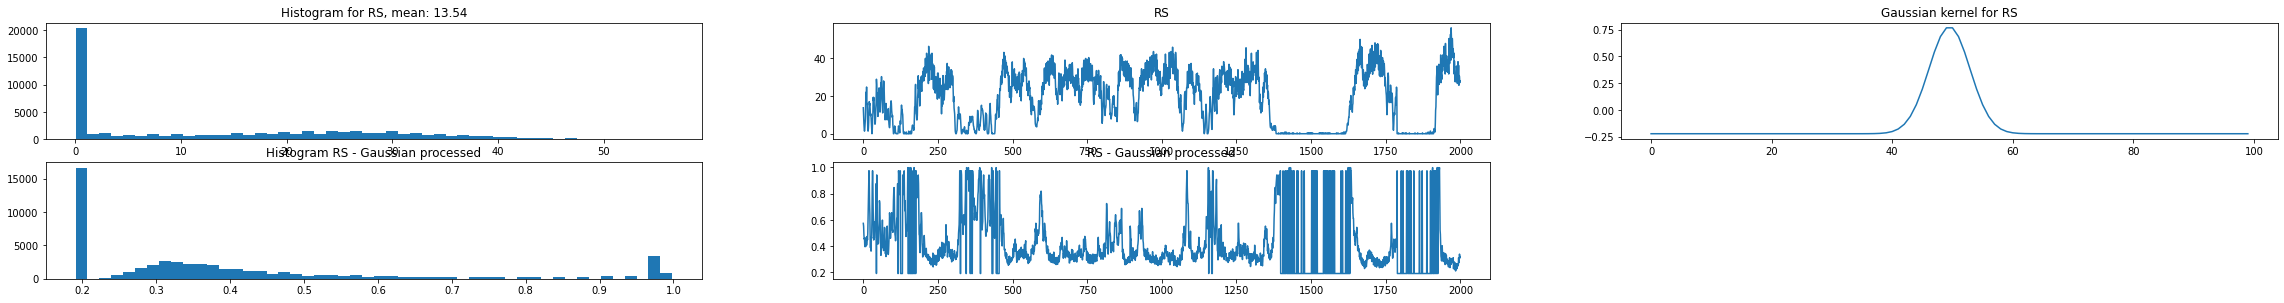

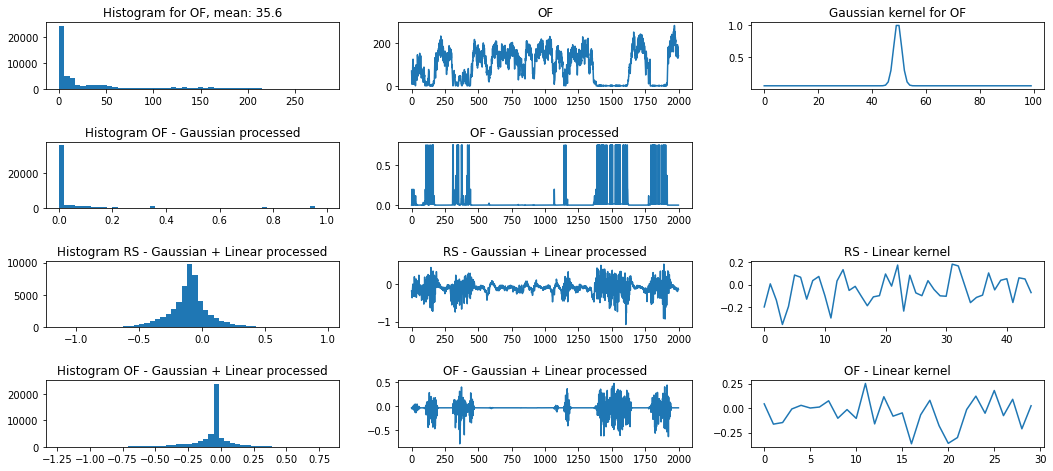

In [143]:
# Plot Gaussian kernel for rs and of
from scipy.signal import gaussian
total_plot_row = 6
total_plot_col = 3
plot_start = 0
plot_end = 2000

plt.figure(figsize=(plot_rows*10,plot_cols*5))
plt.subplot2grid([total_plot_row,total_plot_col],[0,0])
plt.hist(np.power(np.e, rs_x[:,int(frame_rate*np.abs(rs_lag_min))]), bins=50)
plt.title('Histogram for RS, mean: '+ str(np.round(np.mean(np.power(np.e, rs_x[:,int(frame_rate*np.abs(rs_lag_min))])),2)))

plt.subplot2grid([total_plot_row,total_plot_col],[0,1])
plt.plot(np.power(np.e, rs_x[:,int(frame_rate*np.abs(rs_lag_min))])[plot_start: plot_end])
plt.title('RS')

plt.subplot2grid([total_plot_row,total_plot_col],[0,2])
plt.plot(scipy.signal.gaussian(M=100, std=np.power(np.e,params['gaussian_module']['log_sigma']))+params['gaussian_module']['mu'])
plt.title('Gaussian kernel for RS')


def _gaussian(x):
    module = mm.modules.GaussianModule(output_size=1)
    return module(x)
forward_gaussian = hk.without_apply_rng(hk.transform(_gaussian))
rng_key = jax.random.PRNGKey(42)
params_rs_gaussian = forward_gaussian.init(rng=rng_key, x=rs_x)
params_rs_gaussian_dict = hk.data_structures.to_mutable_dict(params_rs_gaussian)
params_rs_gaussian_dict['gaussian_module']['mu'] = jnp.array(params['gaussian_module']['mu'], dtype=jnp.float32)
params_rs_gaussian_dict['gaussian_module']['log_sigma'] = jnp.array(params['gaussian_module']['log_sigma'], dtype=jnp.float32)
params_rs_gaussian = hk.data_structures.to_immutable_dict(params_rs_gaussian_dict)
rs_gaussian = forward_gaussian.apply(params=params_rs_gaussian, x=rs_x)
plt.subplot2grid([total_plot_row,total_plot_col],[1,0])
plt.hist(np.array(rs_gaussian[:,int(frame_rate*rs_lag_min)]), bins=50)
plt.title('Histogram RS - Gaussian processed')

plt.subplot2grid([total_plot_row,total_plot_col],[1,1])
plt.plot(np.array(rs_gaussian[:,int(frame_rate*rs_lag_min)])[plot_start:plot_end])
plt.title('RS - Gaussian processed')

plt.figure(figsize=(15,10))
plt.subplot2grid([total_plot_row,total_plot_col],[2,0])
plt.hist(np.power(np.e, of_x[:,int(frame_rate*np.abs(rs_lag_min))]), bins=50)
plt.title('Histogram for OF, mean: '+ str(np.round(np.mean(np.power(np.e, of_x[:,int(frame_rate*np.abs(rs_lag_min))])),2)))

plt.subplot2grid([total_plot_row,total_plot_col],[2,1])
plt.plot(np.power(np.e, of_x[:,int(frame_rate*np.abs(of_lag_min))])[plot_start: plot_end])
plt.title('OF')

plt.subplot2grid([total_plot_row,total_plot_col],[2,2])
plt.plot(scipy.signal.gaussian(M=100, std=np.power(np.e,params['gaussian_module_1']['log_sigma']))+params['gaussian_module_1']['mu'])
plt.title('Gaussian kernel for OF')

params_of_gaussian = forward_gaussian.init(rng=rng_key, x=of_x)
params_of_gaussian_dict = hk.data_structures.to_mutable_dict(params_of_gaussian)
params_of_gaussian_dict['gaussian_module']['mu'] = jnp.array(params['gaussian_module_1']['mu'], dtype=jnp.float32)
params_of_gaussian_dict['gaussian_module']['log_sigma'] = jnp.array(params['gaussian_module_1']['log_sigma'], dtype=jnp.float32)
params_of_gaussian = hk.data_structures.to_immutable_dict(params_of_gaussian_dict)
of_gaussian = forward_gaussian.apply(params=params_of_gaussian, x=of_x)
plt.subplot2grid([total_plot_row,total_plot_col],[3,0])
plt.hist(np.array(of_gaussian[:,int(frame_rate*of_lag_min)]), bins=50)
plt.title('Histogram OF - Gaussian processed')

plt.subplot2grid([total_plot_row,total_plot_col],[3,1])
plt.plot(np.array(of_gaussian[:,int(frame_rate*of_lag_min)])[plot_start:plot_end])
plt.title('OF - Gaussian processed')

def _linear(x):
    module = hk.Linear(output_size=1)
    return module(x)
linear_step = hk.without_apply_rng(hk.transform(_linear))
rng_key = jax.random.PRNGKey(42)
params_rs_linear = linear_step.init(rng=rng_key, x=rs_gaussian)
params_rs_linear_dict = hk.data_structures.to_mutable_dict(params_rs_linear)
params_rs_linear_dict['linear']['b'] = jnp.array(params['linear']['b'], dtype=jnp.float32)
params_rs_linear_dict['linear']['w'] = jnp.array(params['linear']['w'], dtype=jnp.float32)
params_rs_linear = hk.data_structures.to_immutable_dict(params_rs_linear_dict)
rs_linear = linear_step.apply(params=params_rs_linear, x=rs_gaussian)

plt.subplot2grid([total_plot_row,total_plot_col],[4,0])
plt.hist(np.array(rs_linear), bins=50)
plt.title('Histogram RS - Gaussian + Linear processed')

plt.subplot2grid([total_plot_row,total_plot_col],[4,1])
plt.plot(np.array(rs_linear[plot_start:plot_end]))
plt.title('RS - Gaussian + Linear processed')

plt.subplot2grid([total_plot_row,total_plot_col],[4,2])
plt.plot(params['linear']['b']+params['linear']['w'])
plt.title('RS - Linear kernel')

params_of_linear = linear_step.init(rng=rng_key, x=of_gaussian)
params_of_linear_dict = hk.data_structures.to_mutable_dict(params_of_linear)
params_of_linear_dict['linear']['b'] = jnp.array(params['linear_1']['b'], dtype=jnp.float32)
params_of_linear_dict['linear']['w'] = jnp.array(params['linear_1']['w'], dtype=jnp.float32)
params_of_linear = hk.data_structures.to_immutable_dict(params_of_linear_dict)
of_linear = linear_step.apply(params=params_of_linear, x=of_gaussian)

plt.subplot2grid([total_plot_row,total_plot_col],[5,0])
plt.hist(np.array(of_linear), bins=50)
plt.title('Histogram OF - Gaussian + Linear processed')

plt.subplot2grid([total_plot_row,total_plot_col],[5,1])
plt.plot(np.array(of_linear[plot_start:plot_end]))
plt.title('OF - Gaussian + Linear processed')

plt.subplot2grid([total_plot_row,total_plot_col],[5,2])
plt.plot(params['linear_1']['b']+params['linear_1']['w'])
plt.title('OF - Linear kernel')


plt.tight_layout(pad=2)

 

<ipython-input-31-1033905bfcdf>:17: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(rs_x[:,int(np.abs(rs_lag_min*frame_rate))]))
<ipython-input-31-1033905bfcdf>:21: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(rs_x[:,int(np.abs(rs_lag_min*frame_rate))]),bins=50)


Text(0.5, 1.0, 'Data vs model fit, loss: 36487370.0')

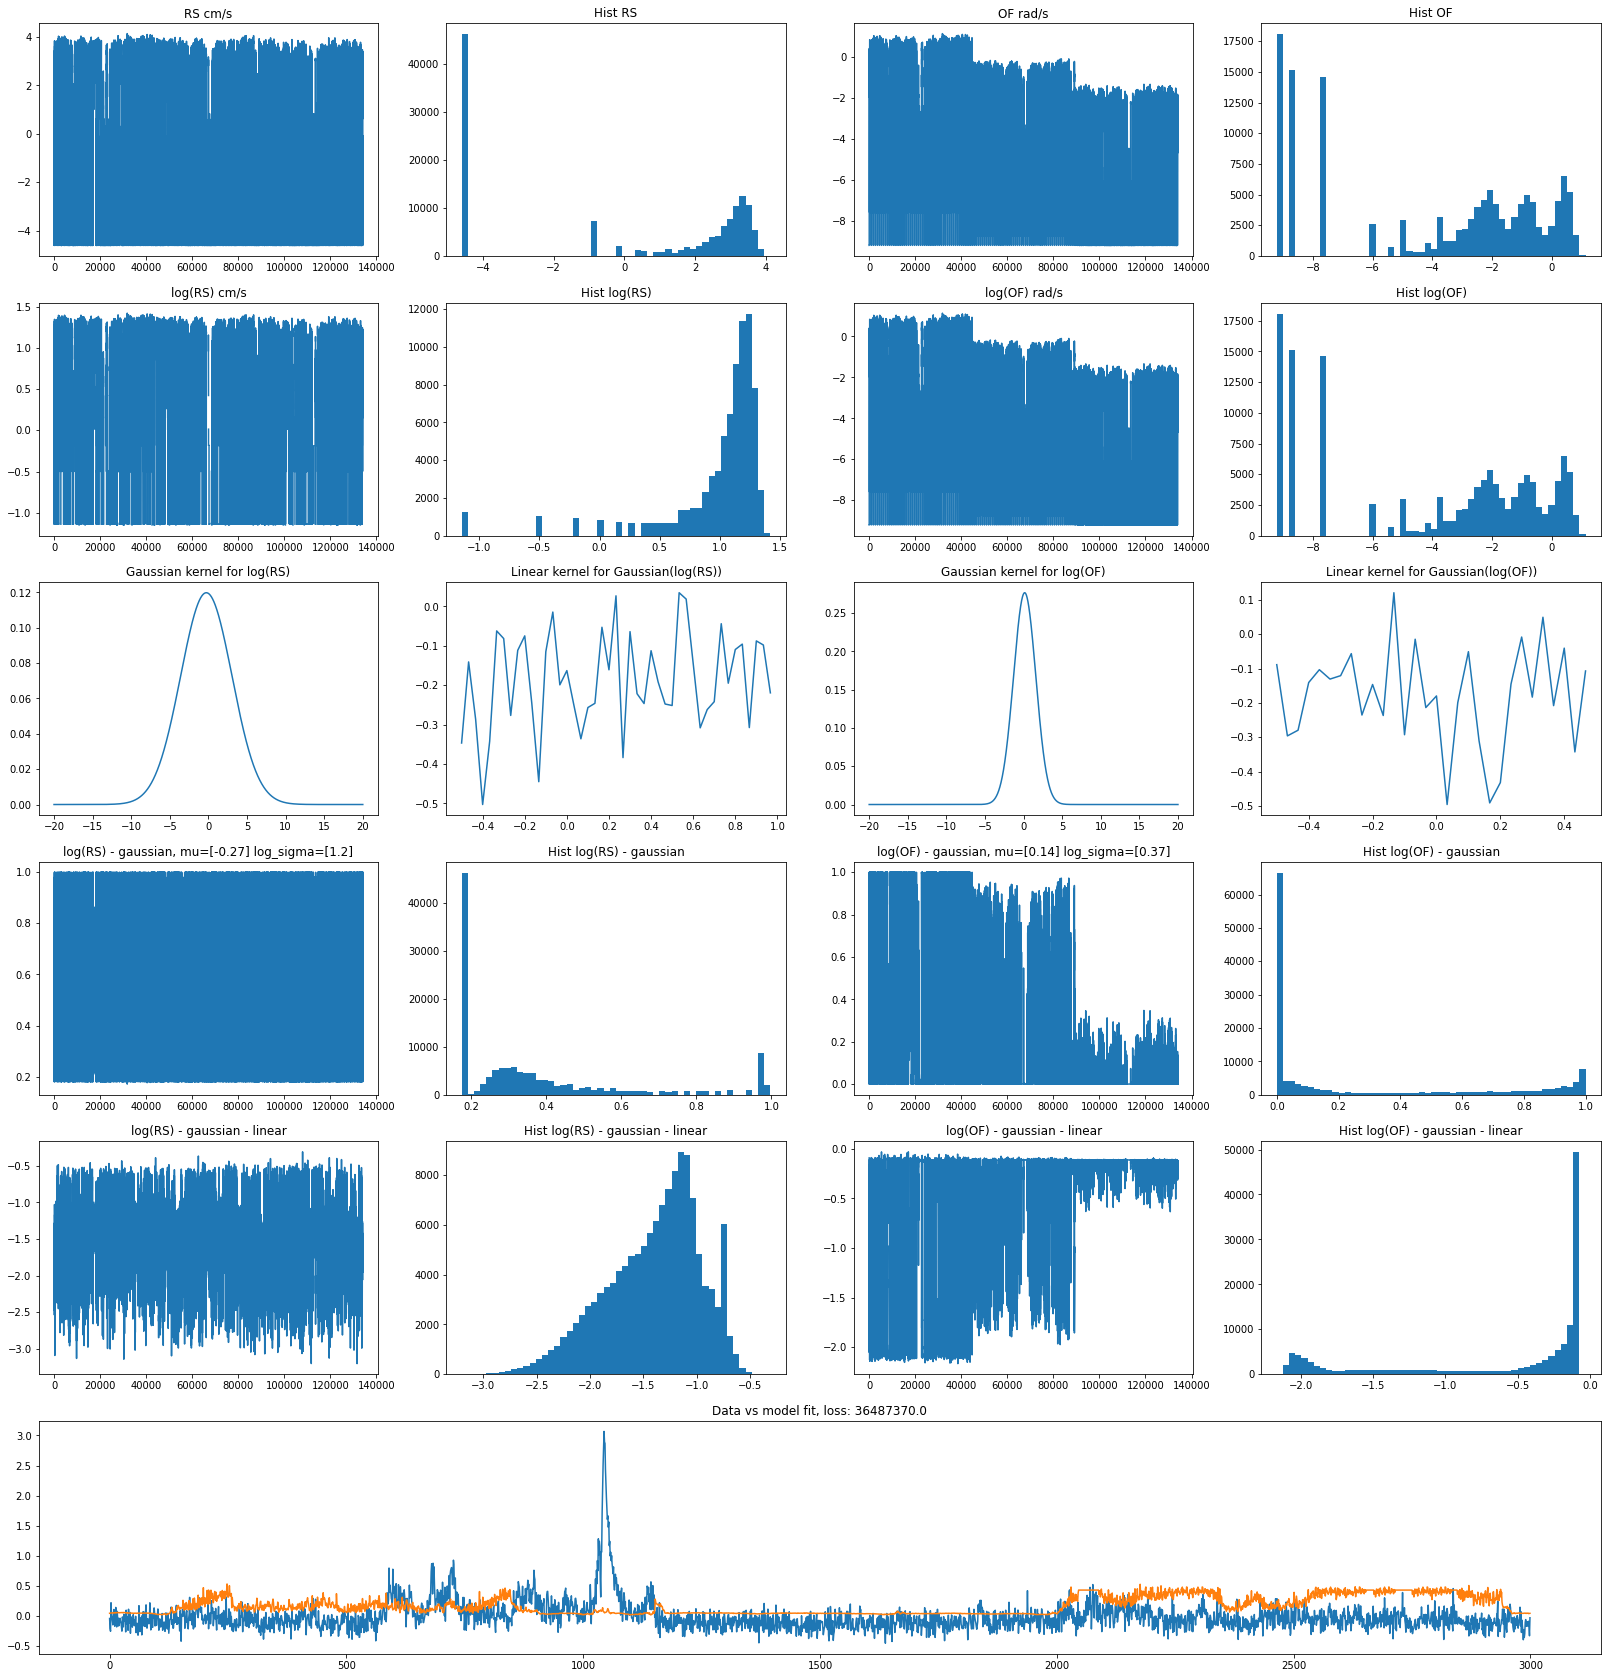

In [31]:
plot_rows = 6
plot_cols = 4
plot_start = 0
plot_end = 1000

# Raw data 
plt.figure(figsize=(7*plot_cols,5*plot_rows))
plt.subplot2grid([plot_rows,plot_cols],[0,0])
plt.plot(rs_x[:,int(np.abs(rs_lag_min*frame_rate))])
plt.title('RS cm/s')

plt.subplot2grid([plot_rows,plot_cols],[0,1])
plt.hist(rs_x[:,int(np.abs(rs_lag_min*frame_rate))],bins=50)
plt.title('Hist RS')

plt.subplot2grid([plot_rows,plot_cols],[1,0])
plt.plot(np.log(rs_x[:,int(np.abs(rs_lag_min*frame_rate))]))
plt.title('log(RS) cm/s')

plt.subplot2grid([plot_rows,plot_cols],[1,1])
plt.hist(np.log(rs_x[:,int(np.abs(rs_lag_min*frame_rate))]),bins=50)
plt.title('Hist log(RS)')

plt.subplot2grid([plot_rows,plot_cols],[0,2])
plt.plot(of_x[:,int(np.abs(rs_lag_min*frame_rate))])
plt.title('OF rad/s')

plt.subplot2grid([plot_rows,plot_cols],[0,3])
plt.hist(of_x[:,int(np.abs(rs_lag_min*frame_rate))],bins=50)
plt.title('Hist OF')

plt.subplot2grid([plot_rows,plot_cols],[1,2])
plt.plot(of_x[:,int(np.abs(rs_lag_min*frame_rate))])
plt.title('log(OF) rad/s')

plt.subplot2grid([plot_rows,plot_cols],[1,3])
plt.hist(of_x[:,int(np.abs(rs_lag_min*frame_rate))],bins=50)
plt.title('Hist log(OF)')

# Gaussian 
plt.subplot2grid([plot_rows,plot_cols],[2,0])
x_axis = np.arange(-20,20,0.001)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])))
plt.title('Gaussian kernel for log(RS)')

plt.subplot2grid([plot_rows,plot_cols],[2,1])
plt.plot(np.arange(len(params['linear']['w']))/frame_rate-np.abs(rs_lag_min), params['linear']['w']+params['linear']['b'])
plt.title('Linear kernel for Gaussian(log(RS))')

plt.subplot2grid([plot_rows,plot_cols],[2,2])
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])))
plt.title('Gaussian kernel for log(OF)')

plt.subplot2grid([plot_rows,plot_cols],[2,3])
plt.plot(np.arange(len(params['linear_1']['w']))/frame_rate-np.abs(rs_lag_min), params['linear_1']['w']+params['linear_1']['b'])
plt.title('Linear kernel for Gaussian(log(OF))')

def initialize_model_params(model, rng_key, x, modules, set_params_name, set_params_value):
    params = model.init(rng=rng_key, x=x)
    params_dict = hk.data_structures.to_mutable_dict(params)
    for module in modules:
        for set_param_name, set_param_value in zip(set_params_name, set_params_value):
            params_dict[module][set_param_name] = jnp.array(set_param_value, dtype=jnp.float32)
    params = hk.data_structures.to_immutable_dict(params_dict)
    
    return params

def _gaussian(x):
    module = mm.modules.GaussianModule(output_size=1)
    return module(x)
forward_gaussian = hk.without_apply_rng(hk.transform(_gaussian))
rng_key = jax.random.PRNGKey(42)
params_rs_gaussian = initialize_model_params(model=forward_gaussian, rng_key=rng_key, x=rs_x, 
                                    modules=['gaussian_module'], 
                                    set_params_name=['mu','log_sigma'], 
                                    set_params_value=[params['gaussian_module']['mu'], params['gaussian_module']['log_sigma']])
rs_gaussian = forward_gaussian.apply(params=params_rs_gaussian, x=rs_x)
params_of_gaussian = initialize_model_params(model=forward_gaussian, rng_key=rng_key, x=rs_x, 
                                    modules=['gaussian_module'], 
                                    set_params_name=['mu','log_sigma'], 
                                    set_params_value=[params['gaussian_module_1']['mu'], params['gaussian_module_1']['log_sigma']])
of_gaussian = forward_gaussian.apply(params=params_of_gaussian, x=of_x)

plt.subplot2grid([plot_rows,plot_cols],[3,0])
plt.plot(rs_gaussian[:,int(np.abs(rs_lag_min)*frame_rate)])
plt.title('log(RS) - gaussian, mu='+str(np.round(np.array(params['gaussian_module']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module']['log_sigma']),2)))

plt.subplot2grid([plot_rows,plot_cols],[3,1])
plt.hist(np.array(rs_gaussian[:,int(np.abs(rs_lag_min)*frame_rate)]),bins=50)
plt.title('Hist log(RS) - gaussian')

plt.subplot2grid([plot_rows,plot_cols],[3,2])
plt.plot(of_gaussian[:,int(np.abs(of_lag_min)*frame_rate)])
plt.title('log(OF) - gaussian, mu='+str(np.round(np.array(params['gaussian_module_1']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module_1']['log_sigma']),2)))

plt.subplot2grid([plot_rows,plot_cols],[3,3])
plt.hist(np.array(of_gaussian[:,int(np.abs(of_lag_min)*frame_rate)]),bins=50)
plt.title('Hist log(OF) - gaussian')

         
# Linear
def _linear(x):
    module = hk.Linear(output_size=1)
    return module(x)
linear_model = hk.without_apply_rng(hk.transform(_linear))
rng_key = jax.random.PRNGKey(42)
params_rs_linear = initialize_model_params(model=linear_model, rng_key=rng_key, x=rs_gaussian, 
                                    modules=['linear'], 
                                    set_params_name=['b','w'], 
                                    set_params_value=[params['linear']['b'], params['linear']['w']])

params_of_linear = initialize_model_params(model=linear_model, rng_key=rng_key, x=of_gaussian, 
                                    modules=['linear'], 
                                    set_params_name=['b','w'], 
                                    set_params_value=[params['linear_1']['b'], params['linear_1']['w']])

rs_linear = linear_model.apply(params=params_rs_linear, x=rs_gaussian)
of_linear = linear_model.apply(params=params_of_linear, x=of_gaussian)

plt.subplot2grid([plot_rows,plot_cols],[4,0])
# plt.plot(rs_linear[plot_start:plot_end])
plt.plot(rs_linear)
plt.title('log(RS) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[4,1])
plt.hist(np.array(rs_linear),bins=50)
plt.title('Hist log(RS) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[4,2])
# plt.plot(of_linear[plot_start:plot_end])
plt.plot(of_linear)
plt.title('log(OF) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[4,3])
plt.hist(np.array(of_linear),bins=50)
plt.title('Hist log(OF) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[5,0], colspan=4)
plt.plot(spikes[6000:9000], label='Data')
plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x)[6000:9000], label='Model fit')
plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1])))
